# Importar los módulos necesarios

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importar bibliotecas del sistema
import os              # Proporciona funciones para interactuar con el sistema operativo.
import time            # Proporciona funciones relacionadas con el tiempo.
import shutil          # Proporciona funciones para operaciones de archivo y directorio.
import pathlib         # Proporciona clases para manipular rutas de archivo y directorio.
import itertools       # Proporciona funciones para crear iteradores.

# importar herramientas de manipulación de datos
import cv2             # Proporciona funciones para leer y manipular imágenes.
import numpy as np     # Proporciona funciones para manipulación de matrices y operaciones numéricas.
import pandas as pd    # Proporciona estructuras de datos y funciones para el análisis de datos.
import seaborn as sns  # Proporciona estilos visuales para gráficos.
sns.set_style('darkgrid')  # Establece el estilo visual de los gráficos.
import matplotlib.pyplot as plt  # Proporciona funciones para trazar gráficos y visualizaciones.
from sklearn.model_selection import train_test_split  # Proporciona funciones para dividir conjuntos de datos en entrenamiento y prueba.
from sklearn.metrics import confusion_matrix, classification_report  # Proporciona funciones para calcular métricas de evaluación de modelos.

# importar bibliotecas de aprendizaje profundo
import tensorflow as tf  # Proporciona un entorno para construir y entrenar modelos de aprendizaje profundo.
from tensorflow import keras  # Proporciona una API de alto nivel para construir y entrenar modelos de aprendizaje profundo.
from tensorflow.keras.models import Sequential  # Proporciona una interfaz para crear modelos secuenciales.
from tensorflow.keras.optimizers import Adam, Adamax  # Proporciona optimizadores para ajustar los pesos del modelo.
from tensorflow.keras.metrics import categorical_crossentropy  # Proporciona una métrica para evaluar el rendimiento del modelo.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Proporciona herramientas para la generación de imágenes aumentadas.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization  # Proporciona capas para construir el modelo de aprendizaje profundo.
from tensorflow.keras import regularizers  # Proporciona regularizadores para controlar el sobreajuste del modelo.

# Ignorar las advertencias
import warnings
warnings.filterwarnings("ignore")

print('módulos cargados')

módulos cargados


# Creación de Funciones necesarias

## Funciones para crear un marco de datos a partir de un conjunto de datos

#### **Función para crear un marco de datos**

In [ ]:
# Generar rutas de archivos con etiquetas
def define_paths(data_dir):
    filepaths = []  # Lista para almacenar las rutas de los archivos
    labels = []     # Lista para almacenar las etiquetas

    folds = os.listdir(data_dir)  # Obtener la lista de carpetas en el directorio de datos
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Obtener la ruta completa de la carpeta
        # Verificar si hay otros archivos en el directorio principal. Si los hay, se ignoran.
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)  # Obtener la lista de archivos en la carpeta
        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Obtener la ruta completa del archivo

            # Verificar si hay otras carpetas
            if pathlib.Path(foldpath).suffix == '':
                # Verificar las máscaras no deseadas
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)  # Obtener la lista de archivos en la subcarpeta
                    for f in o_file:
                        ipath = os.path.join(fpath, f)  # Obtener la ruta completa del archivo
                        filepaths.append(ipath)  # Agregar la ruta del archivo a la lista
                        labels.append(fold)  # Agregar la etiqueta a la lista

            else:
                filepaths.append(fpath)  # Agregar la ruta del archivo a la lista
                labels.append(fold)  # Agregar la etiqueta a la lista

    return filepaths, labels



# Concatenar las rutas de los datos con las etiquetas en un dataframe (para luego ser ajustado en el modelo)
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')  # Crear una serie con las rutas de los archivos
    Lseries = pd.Series(classes, name='labels')  # Crear una serie con las etiquetas
    return pd.concat([Fseries, Lseries], axis=1)  # Concatenar las series en un dataframe

# Dividir el dataframe en conjuntos de entrenamiento, validación y prueba
def split_data(data_dir):
    # Obtener el dataframe de entrenamiento
    files, classes = define_paths(data_dir)  # Obtener las rutas de los archivos y las etiquetas
    df = define_df(files, classes)  # Crear el dataframe con las rutas y etiquetas
    strat = df['labels']  # Definir la columna de etiquetas para el muestreo estratificado
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)  # Dividir el dataframe en entrenamiento y el resto (dummy_df)

    # Obtener los dataframes de validación y prueba
    strat = dummy_df['labels']  # Definir la columna de etiquetas para el muestreo estratificado
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)  # Dividir el dataframe dummy en validación y prueba

    return train_df, valid_df, test_df


#### Función para generar imágenes a partir de marco de datos


In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    Esta función toma los dataframes de entrenamiento, validación y prueba, y los ajusta en un generador de datos de imágenes,
    ya que el modelo toma los datos de un generador de datos de imágenes. El generador de datos de imágenes convierte las imágenes en tensores.
    '''

    # Definir los parámetros del modelo
    img_size = (224, 224)
    channels = 3  # puede ser BGR o escala de grises
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recomendado: usar una función personalizada para el tamaño del lote de datos de prueba, de lo contrario, podemos usar el tamaño de lote normal.
    ts_length = len(test_df) # Calcula el número de muestras en el conjunto de datos de prueba

    # Calcula el tamaño óptimo del lote para el conjunto de datos de prueba.
    # Se busca el divisor más grande de ts_length que sea menor o igual a 80.
    # Esto es útil para asegurar que el tamaño del lote se ajuste bien a la cantidad de datos disponibles.
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

    # Calcula el número de pasos necesarios para procesar todos los datos de prueba en lotes de tamaño test_batch_size
    test_steps = ts_length // test_batch_size

    # Esta función se utilizará en el generador de datos de imágenes para la ampliación de datos. Simplemente toma la imagen y la devuelve.
    def scalar(img):
        return img

    # Crea un generador de datos de imagen para el conjunto de entrenamiento con ampliación de datos (volteo horizontal).
    # Utiliza la función de preprocesamiento personalizada 'scalar'.
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)

    # Crea un generador de datos de imagen para el conjunto de validación y prueba.
    # No se aplica ampliación de datos en estos conjuntos.
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Configura el generador de datos de entrenamiento con las rutas de las imágenes, etiquetas, tamaño de imagen y tamaño de lote.
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    # Configura el generador de datos de validación de manera similar al de entrenamiento.
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    # Configura el generador de datos de prueba. Nota que shuffle=False para mantener el orden de las muestras.
    # Se utiliza un tamaño de lote personalizado calculado previamente.
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=test_batch_size)

    # Devuelve los generadores de datos de entrenamiento, validación y prueba.
    return train_gen, valid_gen, test_gen


#### **Función de Visualización de Datos**

In [ ]:
def show_images(gen):
    '''
    Esta función toma el generador de datos y muestra una muestra de las imágenes.
    '''

    # Obtiene las clases e imágenes que se mostrarán
    g_dict = gen.class_indices  # define el diccionario {'clase': índice}
    classes = list(g_dict.keys())  # define una lista de las claves del diccionario (clases), nombres de las clases: string
    images, labels = next(gen)  # obtiene una muestra de tamaño de lote del generador

    # Calcula el número de muestras a mostrar
    length = len(labels)  # longitud del tamaño de lote
    sample = min(length, 25)  # verifica si hay menos de 25 imágenes en la muestra

    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255  # escala los datos al rango (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # obtiene el índice de la imagen
        class_name = classes[index]  # obtiene la clase de la imagen
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


#### **Callbacks**
Callbacks : Funciones útiles para ayudar a optimizar el entrenamiento del modelo <br>
Ejemplos: detener el entrenamiento del modelo después de un tiempo específico, detener el entrenamiento si no mejora la precisión, etc.

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # especifica cuántas épocas sin mejora antes de ajustar la tasa de aprendizaje
        self.stop_patience = stop_patience  # especifica cuántas veces ajustar la lr sin mejora para detener el entrenamiento
        self.threshold = threshold  # especifica el umbral de precisión de entrenamiento cuando se ajustará la lr en función de la pérdida de validación
        self.factor = factor  # factor por el cual reducir la tasa de aprendizaje
        self.batches = batches  # número de lotes de entrenamiento que se ejecutarán por época
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # guarda este valor para restaurarlo si se reinicia el entrenamiento

        # variables de callback
        self.count = 0  # cuántas veces se ha reducido la lr sin mejora
        self.stop_count = 0
        self.best_epoch = 1  # época con la pérdida más baja
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # obtiene la tasa de aprendizaje inicial y la guarda
        self.highest_tracc = 0.0  # establece la precisión de entrenamiento más alta inicialmente en 0.0
        self.lowest_vloss = np.inf  # establece la pérdida de validación más baja inicialmente en infinito
        self.best_weights = self.model.get_weights()  # establece los mejores pesos en los pesos iniciales del modelo
        self.initial_weights = self.model.get_weights()  # guarda los pesos iniciales si es necesario restaurarlos

    # Define una función que se ejecutará al comienzo del entrenamiento
    def on_train_begin(self, logs=None):
        # Pregunta al usuario si desea que el modelo solicite permiso para detener el entrenamiento
        msg = '¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?'
        print(msg)
        ans = input('')
        # Si el usuario responde 's' o 'S', establece la variable ask_permission en 1
        if ans in ['S', 's']:
            self.ask_permission = 1
        # Si el usuario responde 'n' o 'N', establece la variable ask_permission en 0
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        # Imprime los encabezados de las columnas para el registro de entrenamiento
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        # Guarda el tiempo actual para calcular la duración del entrenamiento más adelante
        self.start_time = time.time()
        self.ep_start = time.time()

    # Define una función que se ejecutará al final del entrenamiento
    def on_train_end(self, logs=None):
        # Guarda el tiempo actual
        stop_time = time.time()
        # Calcula la duración total del entrenamiento en segundos
        tr_duration = stop_time - self.start_time
        # Convierte la duración a horas, minutos y segundos
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        # Imprime la duración del entrenamiento en horas, minutos y segundos
        msg = f'tiempo transcurrido durante el entrenamiento: {str(hours)} horas, {minutes:4.1f} minutos, {seconds:4.2f} segundos)'
        print(msg)

        # Establece los pesos del modelo a los mejores pesos encontrados durante el entrenamiento
        self.model.set_weights(self.best_weights)

    # Define una función que se ejecutará al final de cada lote de entrenamiento
    def on_train_batch_end(self, batch, logs=None):
        # Obtiene la precisión y la pérdida del lote actual y las multiplica por 100 para convertirlas en porcentajes
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # Imprime la precisión y la pérdida del lote actual en la misma línea
        # Esto crea una especie de barra de progreso en la consola
        msg = '{0:20s}procesando lote {1:} de {2:5s} - precisión= {3:5.3f} - pérdida: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')


    # Definimos el método que se ejecutará al final de cada época
    def on_epoch_end(self, epoch, logs=None):
        # Guarda el tiempo actual para calcular la duración de la época
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # obtener la tasa de aprendizaje actual
        current_lr = lr
        acc = logs.get('accuracy')  # obtener la precisión del entrenamiento
        v_acc = logs.get('val_accuracy')  # obtener la precisión de validación
        loss = logs.get('loss')  # obtener la pérdida de entrenamiento para esta época
        v_loss = logs.get('val_loss')  # obtener la pérdida de validación para esta época

        if acc < self.threshold: # si la precisión del entrenamiento está por debajo del umbral, ajustar lr en función de la precisión del entrenamiento
            monitor = 'accuracy' # Establece la variable de monitoreo en 'accuracy' para indicar que se está monitoreando la precisión de entrenamiento

            # Si es la primera época, establece la mejora del progreso en 0
            if epoch == 0:
                pimprov = 0.0

            # De lo contrario, calcula el porcentaje de mejora en la precisión de entrenamiento en comparación con la época anterior
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc # definir la mejora del progreso del modelo


            if acc > self.highest_tracc: # Si la precisión de entrenamiento ha mejorado en esta época
                self.highest_tracc = acc # # Actualiza la precisión de entrenamiento más alta con el valor actual
                self.best_weights = self.model.get_weights() # la precisión del entrenamiento mejoró, así que guardar los pesos
                self.count = 0 # establecer el contador en 0 ya que la precisión del entrenamiento mejoró
                self.stop_count = 0 # establecer el contador de parada en 0

                # Si la pérdida de validación es menor que la pérdida de validación más baja registrada, actualiza la pérdida de validación más baja
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # establecer el valor de la mejor época para esta época

            else:
                # En este bloque, la precisión del entrenamiento no mejoró en la época actual.

                # Verifica si la precisión del entrenamiento no ha mejorado durante un número específico de épocas ('patience').
                # Si es así, es hora de ajustar la tasa de aprendizaje.
                if self.count >= self.patience - 1:
                    # Ajusta la tasa de aprendizaje multiplicándola por un factor (generalmente un valor entre 0 y 1).
                    lr = lr * self.factor

                    # Establece la nueva tasa de aprendizaje en el optimizador del modelo.
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

                    # Restablece el contador de épocas sin mejora a 0, ya que acabamos de ajustar la tasa de aprendizaje.
                    self.count = 0

                    # Incrementa el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                    self.stop_count = self.stop_count + 1

                    # Si la pérdida de validación es menor que la pérdida de validación más baja registrada, actualiza la pérdida de validación más baja.
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    # La precisión del entrenamiento no mejoró, pero aún no hemos alcanzado el límite de 'patience'.
                    # Incrementa el contador de épocas sin mejora.
                    self.count = self.count + 1


        else:
            # En este bloque, la precisión del entrenamiento está por encima de un umbral predefinido,
            # por lo que ajustaremos la tasa de aprendizaje en función de la pérdida de validación.

            # Establece la variable de monitoreo en 'val_loss' para indicar que se está monitoreando la pérdida de validación.
            monitor = 'val_loss'

            # Si es la primera época, establece la mejora del progreso en 0.
            if epoch == 0:
                pimprov = 0.0
            # De lo contrario, calcula el porcentaje de mejora en la pérdida de validación en comparación con la época anterior.
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            # Si la pérdida de validación ha mejorado en esta época.
            if v_loss < self.lowest_vloss:
                # Actualiza la pérdida de validación más baja con el valor actual.
                self.lowest_vloss = v_loss

                # Guarda los pesos del modelo, ya que la pérdida de validación ha mejorado.
                self.best_weights = self.model.get_weights()

                # Restablece el contador de épocas sin mejora a 0, ya que hubo una mejora en esta época.
                self.count = 0

                # Restablece el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                self.stop_count = 0

                # Actualiza la mejor época con la época actual (las épocas están indexadas desde 1).
                self.best_epoch = epoch + 1
            else:
                # La pérdida de validación no mejoró.

                # Verifica si la pérdida de validación no ha mejorado durante un número específico de épocas ('patience').
                # Si es así, es hora de ajustar la tasa de aprendizaje.
                if self.count >= self.patience - 1:
                    # Ajusta la tasa de aprendizaje multiplicándola por un factor (generalmente un valor entre 0 y 1).
                    lr = lr * self.factor

                    # Incrementa el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                    self.stop_count = self.stop_count + 1

                    # Restablece el contador de épocas sin mejora a 0, ya que acabamos de ajustar la tasa de aprendizaje.
                    self.count = 0

                    # Establece la nueva tasa de aprendizaje en el optimizador del modelo.
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    # La pérdida de validación no mejoró, pero aún no hemos alcanzado el límite de 'patience'.
                    # Incrementa el contador de épocas sin mejora.
                    self.count = self.count + 1

                # Si la precisión del entrenamiento es mayor que la precisión más alta registrada, actualiza la precisión más alta.
                if acc > self.highest_tracc:
                    self.highest_tracc = acc


        # Formatea y muestra un mensaje con información sobre la época actual, incluyendo pérdida, precisión, tasa de aprendizaje, etc.
        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        # Verifica si la tasa de aprendizaje se ha ajustado 'stop_patience' veces sin mejoras.
        if self.stop_count > self.stop_patience - 1:
            # Si es así, muestra un mensaje indicando que el entrenamiento se detendrá.
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)

            # Detiene el entrenamiento.
            self.model.stop_training = True
        else:
            # Si el usuario ha configurado 'ask_epoch' y ha dado permiso para preguntar, verifica si se ha alcanzado la época especificada.
            if self.ask_epoch is not None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    # Pregunta al usuario si desea detener el entrenamiento o continuar durante un número específico de épocas.
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    # Recibe la entrada del usuario.
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        # Si el usuario ingresa 'H' o 'h', detiene el entrenamiento y muestra un mensaje.
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True
                    else:
                        # Si el usuario ingresa un número, establece la nueva época en la que se preguntará nuevamente.
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except Exception:
                            # Si la entrada no es válida, muestra un mensaje de error.
                            print('Invalid')

#### **Función para trazar el historial de entrenamiento**

In [ ]:
def plot_training(hist):
    '''
    Esta función toma el modelo de entrenamiento y traza el historial de precisión y pérdidas con la mejor época en ambos.
    '''

    # Definir variables necesarias
    tr_acc = hist.history['accuracy']    # Precisión de entrenamiento en cada época
    tr_loss = hist.history['loss']       # Pérdida de entrenamiento en cada época
    val_acc = hist.history['val_accuracy']    # Precisión de validación en cada época
    val_loss = hist.history['val_loss']       # Pérdida de validación en cada época
    index_loss = np.argmin(val_loss)    # Índice de la pérdida de validación más baja
    val_lowest = val_loss[index_loss]   # Valor de la pérdida de validación más baja
    index_acc = np.argmax(val_acc)      # Índice de la precisión de validación más alta
    acc_highest = val_acc[index_acc]    # Valor de la precisión de validación más alta
    Epochs = [i+1 for i in range(len(tr_acc))]    # Lista de épocas (1, 2, 3, ...)
    loss_label = f'best epoch= {str(index_loss + 1)}'   # Etiqueta para la mejor época de pérdida
    acc_label = f'best epoch= {str(index_acc + 1)}'     # Etiqueta para la mejor época de precisión

    # Graficar el historial de entrenamiento
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')    # Gráfico de pérdida de entrenamiento
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')  # Gráfico de pérdida de validación
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)   # Punto de la mejor época de pérdida
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')   # Gráfico de precisión de entrenamiento
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy') # Gráfico de precisión de validación
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)    # Punto de la mejor época de precisión
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()    # Ajustar el diseño de los subgráficos
    plt.show()


#### **Función para crear una matriz de confusión**

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    Esta función traza la matriz de confusión.
    Puede mostrar la matriz de confusión en forma normalizada o sin normalizar.
    '''

    # Crea una figura de tamaño 10x10.
    plt.figure(figsize=(10, 10))

    # Muestra los datos como una imagen; es decir, en un mapa de colores regular.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    # Agrega un título a la figura.
    plt.title(title)

    # Agrega una barra de colores a la figura.
    plt.colorbar()

    # Define las marcas de graduación en los ejes x e y.
    tick_marks = np.arange(len(classes))

    # Agrega las etiquetas de clase a los ejes x e y.
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normaliza la matriz de confusión dividiendo cada fila por la suma de esa fila si normalize=True.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    # Imprime la matriz de confusión en la consola.
    print(cm)

    # Establece el umbral para el color del texto en las celdas de la matriz de confusión.
    thresh = cm.max() / 2.

    # Itera sobre cada celda de la matriz de confusión y agrega el valor de la celda como texto.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Ajusta el diseño para que todo encaje en la figura.
    plt.tight_layout()

    # Etiqueta los ejes.
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# **Estructura del Modelo**

#### **Empezamos a leer el conjunto de datos**

In [ ]:
data_dir = '/content/drive/MyDrive/IMGDatasetPollo'

try:
    # Obtener los conjuntos de datos divididos
    train_df, valid_df, test_df = split_data(data_dir)

    # Obtener los generadores
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')


Found 620 validated image filenames belonging to 2 classes.
Found 77 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


#### **Visualización de la imágenes**

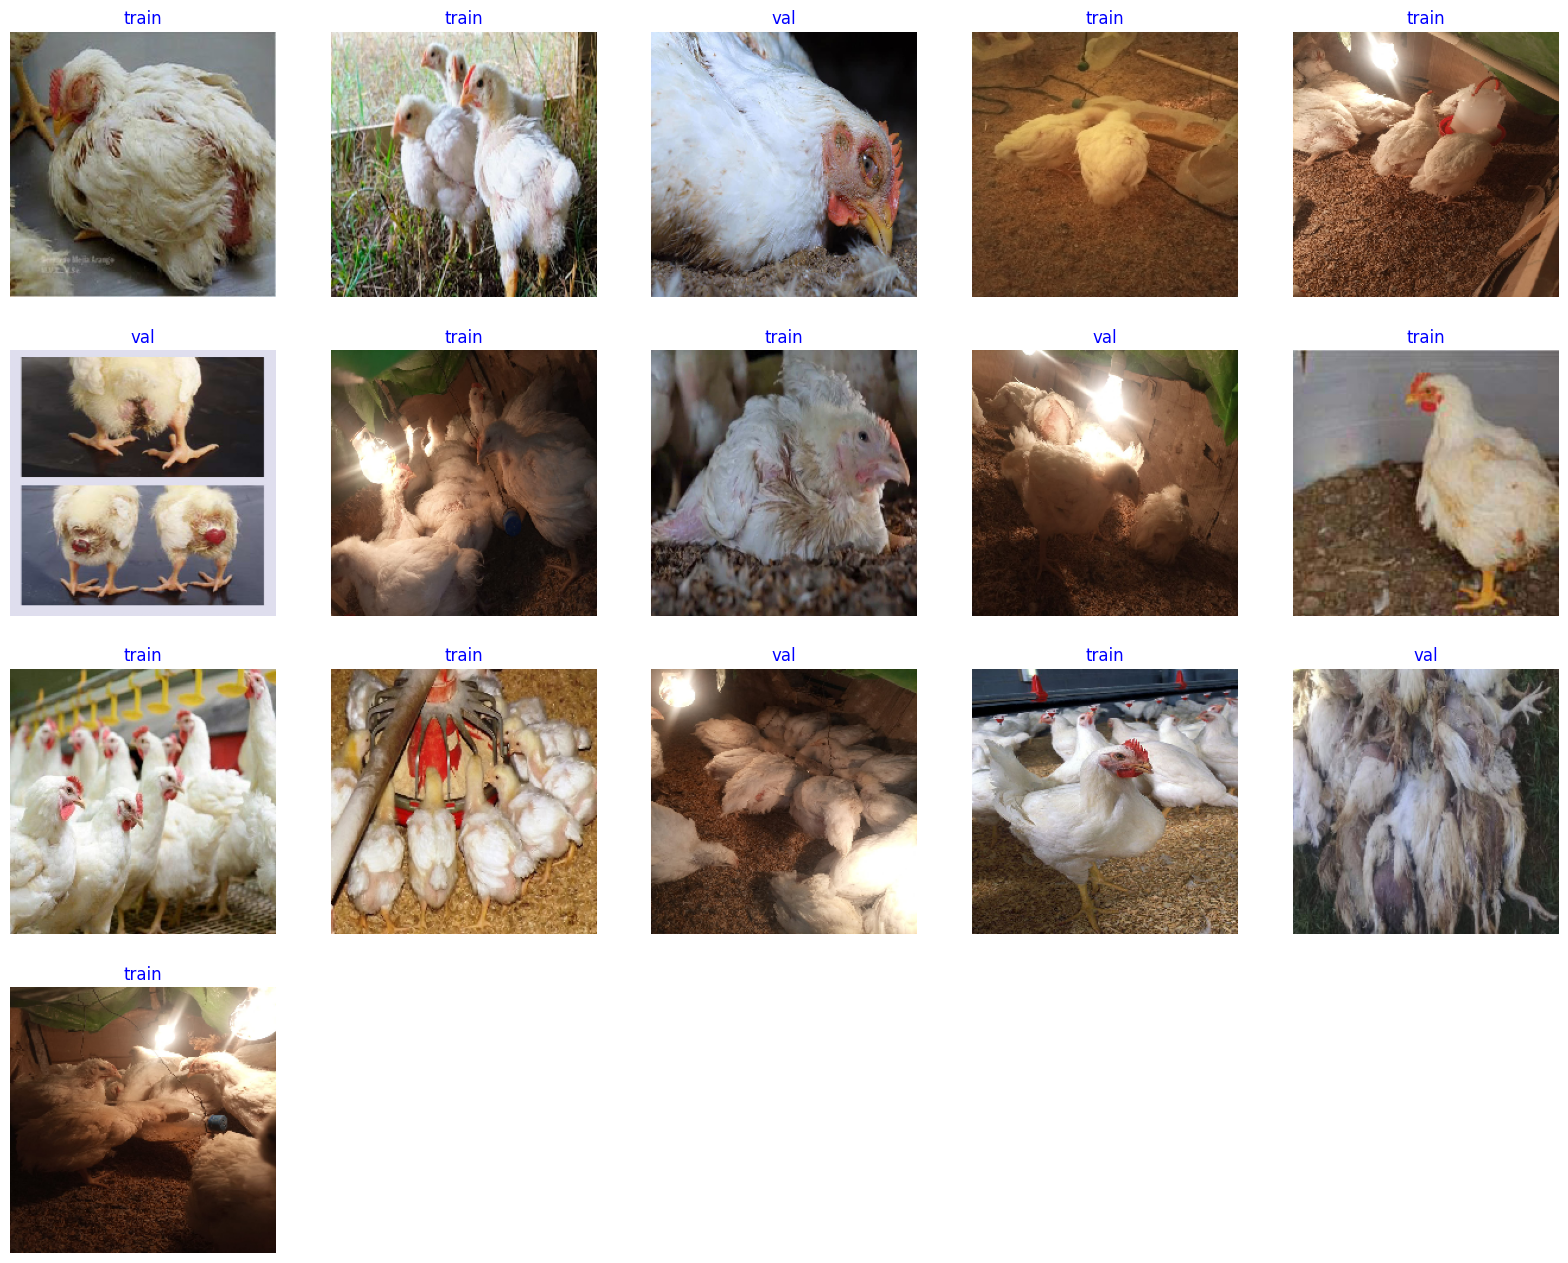

In [ ]:
show_images(train_gen)

#### **Creación del Modelo Genérico**

In [ ]:
# Crear la estructura del modelo
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
# En este caso, utilizaremos VGG19 como modelo base.
base_model = tf.keras.applications.densenet.DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense_1 (Dense)             (None, 2)                 3330      
                                                                 
Total params: 12,646,210
Trainable params: 12,487,810
Non-trainable params: 158,400
_________________________________________________________________


#### **Establecemos parámetros del Callback**

In [ ]:
batch_size = 16  # establecer el tamaño del lote para el entrenamiento
epochs = 10  # número total de épocas en el entrenamiento
patience = 3  # número de épocas a esperar para ajustar lr si el valor monitoreado no mejora
stop_patience = 10  # número de épocas a esperar antes de detener el entrenamiento si el valor monitoreado no mejora
threshold = 0.9  # si la precisión del entrenamiento es < umbral, ajustar el valor monitoreado de precisión; de lo contrario, monitorear la pérdida de validación
factor = 0.5  # factor para reducir el lr
ask_epoch = 5  # número de épocas para ejecutar antes de preguntar si quieres detener el entrenamiento
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # número de lotes de entrenamiento para ejecutar por época

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
            factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]


#### **Entrenamiento del modelo**

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     2.584   48.871   5.20884  42.857   0.00100  0.00100  accuracy     0.00    384.04 
 2 /10     1.236   47.258  22.03504  38.961   0.00100  0.00100  accuracy    -3.30    761.48 
 3 /10     0.837   51.935   0.72759  54.545   0.00100  0.00100  accuracy     6.27   1139.67 
 4 /10     0.994   48.548   0.83947  42.857   0.00100  0.00100  accuracy    -6.52   1533.04 
 5 /10     1.028   47.581  10.47652  46.753   0.00100  0.00100  accuracy    -8.39   1904.72 
 6 /10     0.782   51.290   1.15638  46.753   0.00100  0.00050  accuracy    -1.24   2289.79 
 7 /10     0.851   47.742   1.54605  45.455   0.00050  0.00050  accuracy    -8.07   2663.53 
 8 /10     0.772   51.452   1.92185  35.065   0.00050  0.00050  accuracy    -0.93   3002.24 
 9 /10     0.772   51.290   3.31400  44.156   0.00050  0.00025  accuracy    -1.24   3382.59 
10 /

#### **Mostrar rendimiento del modelo**

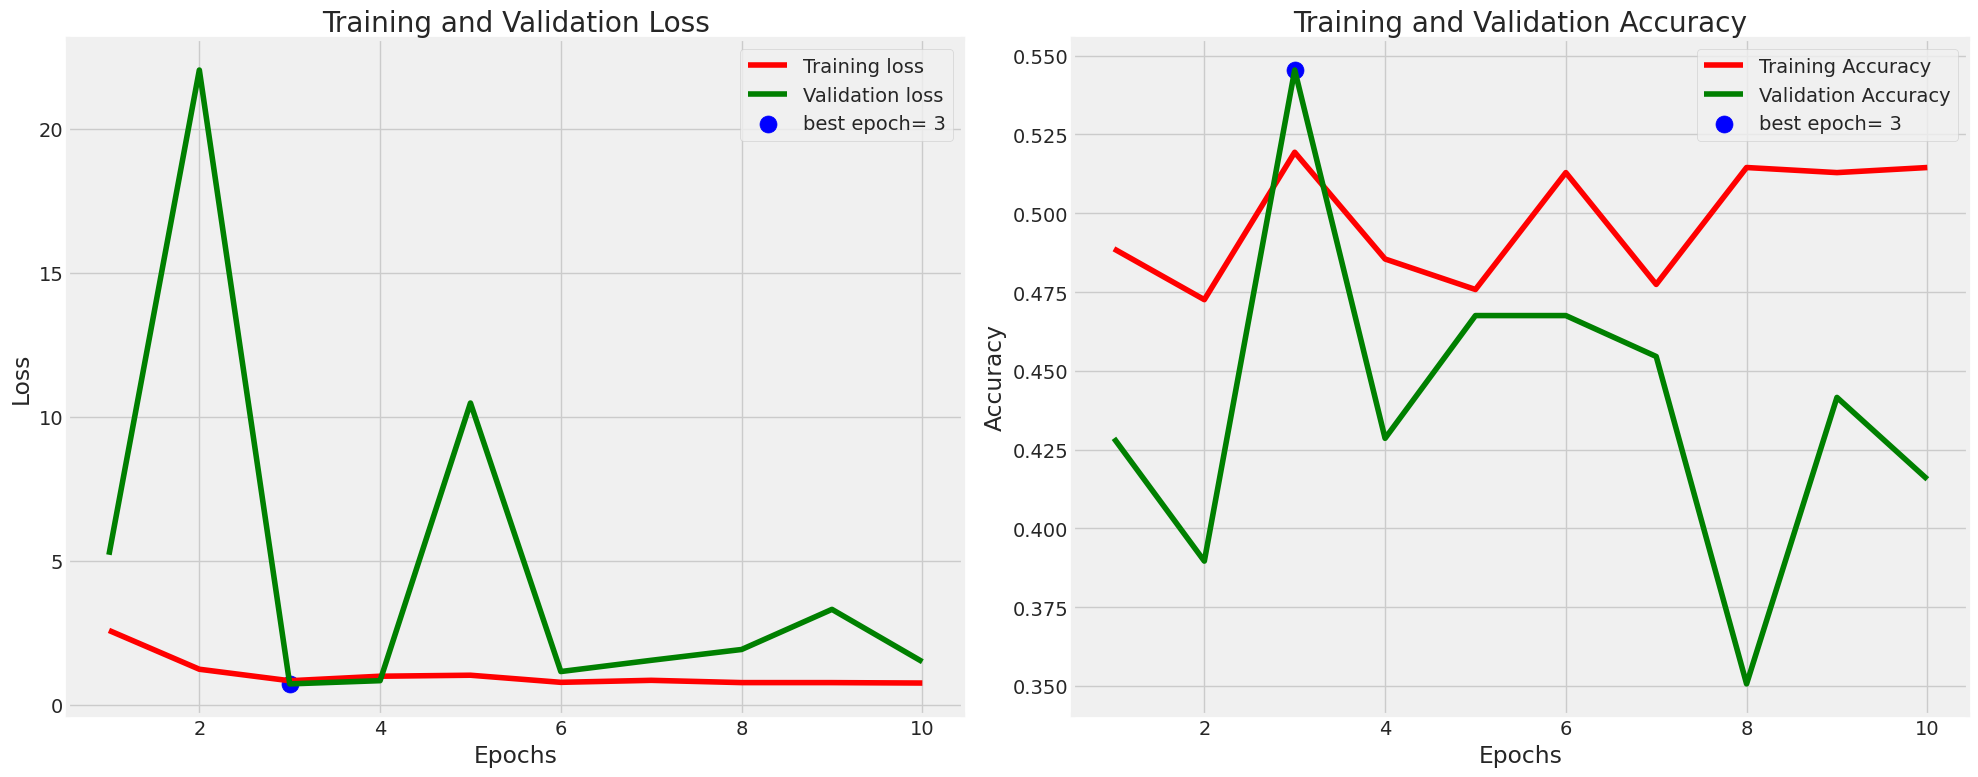

In [ ]:
plot_training(history)

# **Evaluación del modelo**

In [ ]:
ts_length = len(test_df)  # longitud del conjunto de datos de prueba
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# tamaño del lote para el conjunto de datos de prueba
test_steps = ts_length // test_batch_size  # número de pasos para ejecutar el conjunto de datos de prueba en el modelo

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de entrenamiento
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de validación
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de prueba

print("Train Loss: ", train_score[0])  # mostrar la pérdida en el conjunto de datos de entrenamiento
print("Train Accuracy: ", train_score[1])  # mostrar la precisión en el conjunto de datos de entrenamiento
print('-' * 20)
print("Validation Loss: ", valid_score[0])  # mostrar la pérdida en el conjunto de datos de validación
print("Validation Accuracy: ", valid_score[1])  # mostrar la precisión en el conjunto de datos de validación
print('-' * 20)
print("Test Loss: ", test_score[0])  # mostrar la pérdida en el conjunto de datos de prueba
print("Test Accuracy: ", test_score[1])  # mostrar la precisión en el conjunto de datos de prueba


1/1 [==============================] - 12s 12s/step - loss: 0.7504 - accuracy: 0.5128
Train Loss:  0.6892654895782471
Train Accuracy:  0.5625
--------------------
Validation Loss:  0.7087897658348083
Validation Accuracy:  0.5625
--------------------
Test Loss:  0.7503799796104431
Test Accuracy:  0.5128205418586731


# **Obtención de las Predicciones**

In [ ]:
preds = model.predict_generator(test_gen)  # obtener las predicciones del modelo en el generador de datos de prueba
y_pred = np.argmax(preds, axis=1)  # obtener las clases predichas (índice con mayor probabilidad) a partir de las predicciones
print(y_pred)  # imprimir las clases predichas

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


- Precisión: Es la proporción de verdaderos positivos sobre el total de positivos predichos (verdaderos positivos + falsos positivos).
- Recall (Sensibilidad): Es la proporción de verdaderos positivos sobre el total de positivos reales (verdaderos positivos + falsos negativos).
- F1-score: Es una medida que combina precisión y recall utilizando la media armónica.
- Support: Es el número de muestras de la clase verdadera en el conjunto de datos.

#### **Matrices de confusión e informe de clasificación**

Confusion Matrix, Without Normalization
[[40  0]
 [38  0]]
              precision    recall  f1-score   support

       train       0.51      1.00      0.68        40
         val       0.00      0.00      0.00        38

    accuracy                           0.51        78
   macro avg       0.26      0.50      0.34        78
weighted avg       0.26      0.51      0.35        78



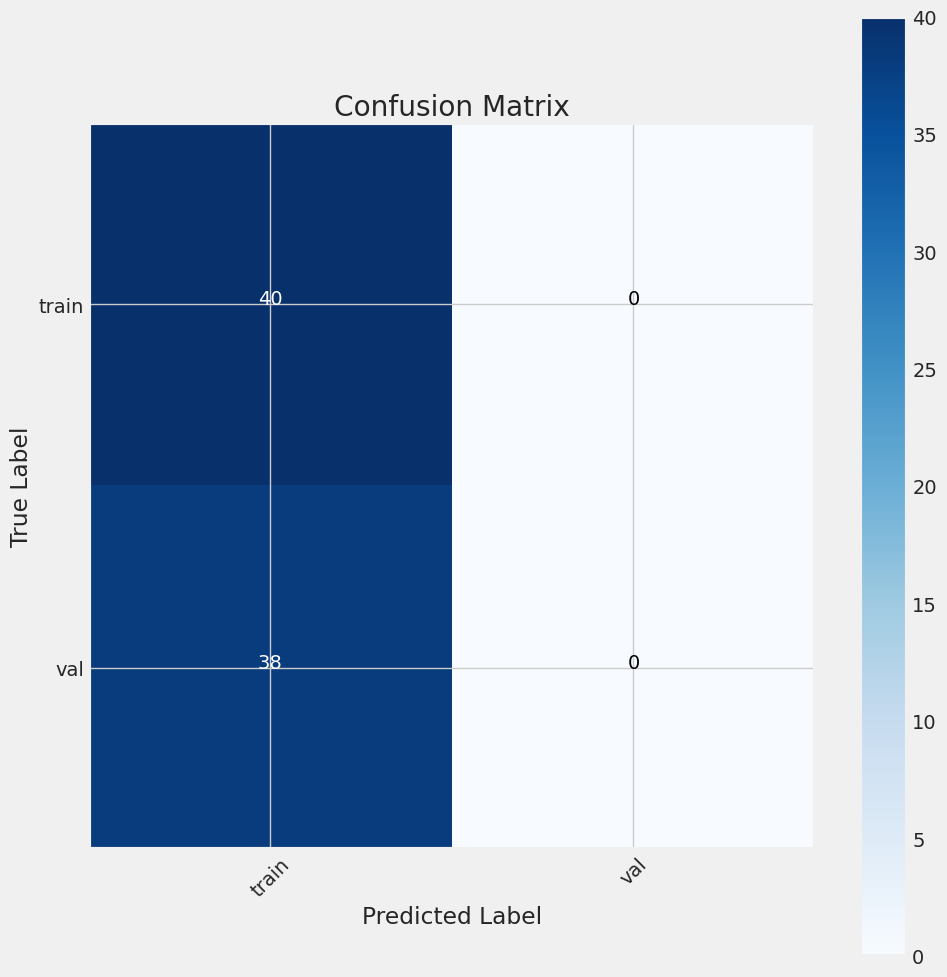

In [ ]:
g_dict = test_gen.class_indices  # obtener el diccionario de índices de clases del generador de datos de prueba
classes = list(g_dict.keys())  # obtener la lista de nombres de clases a partir de las claves del diccionario

# Matriz de confusión
cm = confusion_matrix(test_gen.classes, y_pred)  # calcular la matriz de confusión utilizando las clases reales y las clases predichas
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')  # graficar la matriz de confusión

# Reporte de clasificación
print(classification_report(test_gen.classes, y_pred, target_names=classes))  # imprimir el reporte de clasificación que incluye precision, recall, F1-score, y soporte para cada clase


#### **Save model**

In [ ]:
model_name = model.input_names[0][:-6]  # obtener el nombre del modelo eliminando los últimos 6 caracteres del primer nombre de entrada
subject = 'Pollos'  # definir el nombre del tema o sujeto (en este caso, pollos)
acc = test_score[1] * 100  # obtener la precisión del modelo en el conjunto de pruebas y multiplicar por 100 para obtener el porcentaje de precisión
save_path = ''  # definir la ruta de guardado (puede especificar la ubicación donde desea guardar el modelo y los pesos)

# Guardar modelo
save_id = str(f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5')  # construir el nombre del archivo de guardado utilizando el nombre del modelo, el tema y la precisión redondeada
model_save_loc = os.path.join(save_path, save_id)  # unir la ruta de guardado con el nombre del archivo de guardado
model.save(model_save_loc)  # guardar el modelo en la ubicación especificada
print(f'model was saved as {model_save_loc}')  # imprimir el mensaje indicando la ubicación donde se guardó el modelo

# Guardar pesos
weight_save_id = str(f'{model_name}-{subject}-weights.h5')  # construir el nombre del archivo de guardado de pesos utilizando el nombre del modelo y el tema
weights_save_loc = os.path.join(save_path, weight_save_id)  # unir la ruta de guardado con el nombre del archivo de guardado de pesos
model.save_weights(weights_save_loc)  # guardar los pesos del modelo en la ubicación especificada
print(f'weights were saved as {weights_save_loc}')  # imprimir el mensaje indicando la ubicación donde se guardaron los pesos


model was saved as densenet169-Pollos-51.28.h5
weights were saved as densenet169-Pollos-weights.h5


#### **Generación de archivos CSV con índices de clase y tamaño de imagen**

In [ ]:
class_dict = train_gen.class_indices  # obtener el diccionario de índices de clase del generador de entrenamiento
img_size = train_gen.image_shape  # obtener el tamaño de imagen del generador de entrenamiento
height = []  # lista vacía para almacenar las alturas
width = []  # lista vacía para almacenar los anchos

# Iterar sobre el número de clases y agregar las alturas y anchos correspondientes
for _ in range(len(class_dict)):
    height.append(img_size[0])  # agregar la altura al final de la lista de alturas
    width.append(img_size[1])  # agregar el ancho al final de la lista de anchos

# Crear series de pandas para los índices de clase, las clases, las alturas y los anchos
Index_series = pd.Series(list(class_dict.values()), name='class_index')  # convertir los valores del diccionario de índices de clase en una serie
Class_series = pd.Series(list(class_dict.keys()), name='class')  # convertir las claves del diccionario de índices de clase en una serie
Height_series = pd.Series(height, name='height')  # convertir la lista de alturas en una serie
Width_series = pd.Series(width, name='width')  # convertir la lista de anchos en una serie

# Concatenar las series en un DataFrame
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

# Crear el nombre del archivo CSV usando el nombre del tema y la extensión '.csv'
csv_name = f'{subject}-class_dict.csv'

# Unir la ruta de guardado con el nombre del archivo CSV
csv_save_loc = os.path.join(save_path, csv_name)

# Guardar el DataFrame en formato CSV sin incluir el índice
class_df.to_csv(csv_save_loc, index=False)

# Imprimir el mensaje indicando la ubicación donde se guardó el archivo CSV
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Pollos-class_dict.csv
